# EcoSort Waste Management Assistant
# Module 8 Summative Lab

## Overview

You are a data scientist at "EcoSort," a technology company that specializes in developing AI solutions for waste management. EcoSort has partnered with Metro City's waste management department to develop an intelligent waste management assistant that can help residents properly dispose of waste items so less time is spent sorting material at facilities.

This assistant needs to:

1. Identify waste materials from images uploaded by residents (CNN)
2. Classify waste items based on text descriptions provided by residents (RNN/Transformer)
3. Generate specific recycling instructions based on identified waste type and city policies (Generative Transformer with RAG)

Your task is to build this integrated system using the RealWaste dataset along with generated text data that simulates real-world waste management operations.

## Part 1: Dataset Exploration and Preparation

In this section, you will explore and prepare the datasets for your models.

### 1.1 Load and Explore the RealWaste Dataset

In [1]:
# Import necessary libraries
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from sentence_transformers import SentenceTransformer
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, regularizers, Model, Sequential




# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [2]:
# TODO: Load and explore the RealWaste dataset
# - Dataset structure
# - Distribution of waste categories
# - Image characteristics (resolution, quality, background)

df = pd.read_csv("Waste Descriptions.csv")
print("Dataset columns:", df.columns.tolist())
print(df.head(3))



Dataset columns: ['description', 'category', 'disposal_instruction', 'common_confusion', 'material_composition']
                                         description       category  \
0                           soiled silver tablecloth  Textile Trash   
1                        folded glass bottle leaking          Glass   
2  large Supermarket vegetable waste with food re...  Food Organics   

                                disposal_instruction common_confusion  \
0  Look for textile recycling programs in your area.              NaN   
1     Remove caps, lids, and corks before recycling.              NaN   
2   If no compost available, place in general waste.              NaN   

                                material_composition  
0  Fabric made from natural or synthetic fibers, ...  
1  Silica-based material, may contain additives f...  
2  Biodegradable matter derived from plant or ani...  


### 1.2 Explore Text Datasets


Category distribution:
category
Vegetation             600
Textile Trash          586
Cardboard              584
Miscellaneous Trash    578
Plastic                569
Glass                  551
Food Organics          518
Metal                  508
Paper                  506
Name: count, dtype: int64


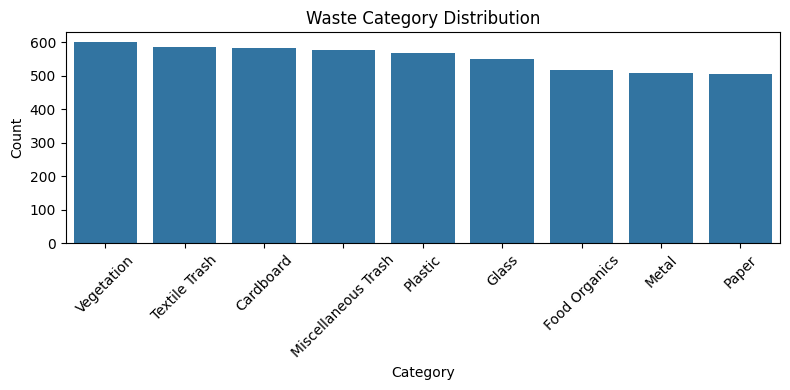


Number of image files: 4752
Image count per category: {'Paper': 500, 'Metal': 790, 'Cardboard': 461, 'Food Organics': 411, 'Glass': 420, 'Vegetation': 436, 'Textile Trash': 318, 'Miscellaneous Trash': 495, 'Plastic': 921}
Image resolution (sample):
  Mean width: 524.0 Mean height: 524.0
  Min width: 524 Max width: 524


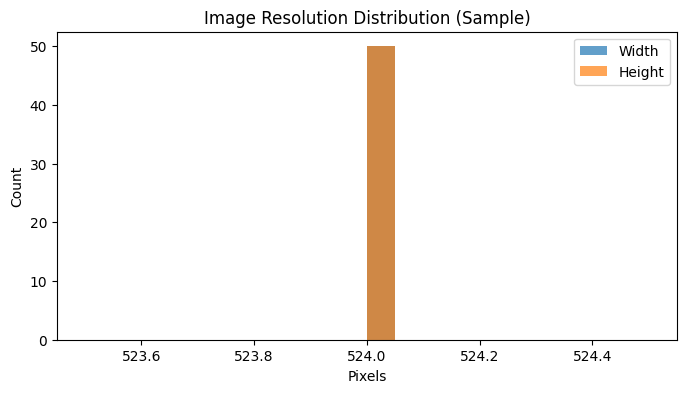

In [3]:
# TODO: Load and explore the waste description text data
# - Load waste_descriptions.csv
# - Analyze vocabulary and structure
# - Understand the distribution of categories
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Load your waste_descriptions.csv
df = pd.read_csv('Waste Descriptions.csv')

# Analyze category distribution
print("\nCategory distribution:")
print(df['category'].value_counts())
plt.figure(figsize=(8,4))
sns.countplot(data=df, x="category", order=df['category'].value_counts().index)
plt.title("Waste Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Find all images inside subfolders (recursively)
image_dir = "./realwaste-main/RealWaste"
image_files = []
category_counts = {}

if os.path.exists(image_dir):
    for root, dirs, files in os.walk(image_dir):
        for f in files:
            if f.lower().endswith(('.jpg', '.png', '.jpeg')):
                full_path = os.path.join(root, f)
                image_files.append(full_path)
                # Track counts per category (folder name)
                category = os.path.basename(root)
                category_counts[category] = category_counts.get(category, 0) + 1

    print(f"\nNumber of image files: {len(image_files)}")
    print("Image count per category:", category_counts)

    # Check a sample of image sizes
    widths, heights = [], []
    for img_path in image_files[:50]:  # sample first 50 images
        try:
            with Image.open(img_path) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
        except Exception as e:
            print(f"Error reading {img_path}: {e}")

    if widths and heights:
        print("Image resolution (sample):")
        print("  Mean width:", np.mean(widths), "Mean height:", np.mean(heights))
        print("  Min width:", np.min(widths), "Max width:", np.max(widths))
        plt.figure(figsize=(8,4))
        plt.hist(widths, bins=20, alpha=0.7, label='Width')
        plt.hist(heights, bins=20, alpha=0.7, label='Height')
        plt.title("Image Resolution Distribution (Sample)")
        plt.xlabel("Pixels")
        plt.ylabel("Count")
        plt.legend()
        plt.show()
    else:
        print("No image sizes to display (files might be corrupted or unreadable).")
else:
    print("Image directory not found. Skipping image resolution analysis.")


In [4]:
# TODO: Load and explore the waste policy documents
# - Load waste_policy_documents.csv
# - Understand document organization and language


policy_df = pd.read_csv('./Waste Descriptions.csv')
print("Columns:", policy_df.columns.tolist())
print(policy_df.head())

print(policy_df.columns.tolist())
print(policy_df.head())

Columns: ['description', 'category', 'disposal_instruction', 'common_confusion', 'material_composition']
                                         description       category  \
0                           soiled silver tablecloth  Textile Trash   
1                        folded glass bottle leaking          Glass   
2  large Supermarket vegetable waste with food re...  Food Organics   
3                         intact floral carpet piece  Textile Trash   
4                  empty fun-sized purple apple core  Food Organics   

                                disposal_instruction  \
0  Look for textile recycling programs in your area.   
1     Remove caps, lids, and corks before recycling.   
2   If no compost available, place in general waste.   
3  Look for textile recycling programs in your area.   
4           Keep separate from recyclable materials.   

                                    common_confusion  \
0                                                NaN   
1                  

### 1.3 Create Data Pipelines

In [5]:
import pathlib

# Parameters
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

data_dir = pathlib.Path('./realwaste-main/RealWaste')
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
num_classes = len(class_names)

# Data split
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Split val_ds in half to create a test set
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data augmentation
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="augmentation")

# Build the model
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
base_model.trainable = True  

inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',  # label_mode='categorical'
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.
Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.3083 - loss: 2.1048 - val_accuracy: 0.6489 - val_loss: 1.2295 - learning_rate: 1.0000e-04
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.7082 - loss: 1.1104 - val_accuracy: 0.7234 - val_loss: 0.9443 - learning_rate: 1.0000e-04
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.8110 - loss: 0.7726 - val_accuracy: 0.7702 - val_loss: 0.8364 - learning_rate: 1.0000e-04
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.8685 - loss: 0.5910 - val_accuracy: 0.7638 - val_loss: 0.8463 - learning_rate: 1.0000e-04
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.8960 - loss: 0.4884 - val_accuracy: 0.7872 - val_loss: 0.7868 - learning_rate: 1.0000e-04
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.931

In [10]:
# TODO: Create a text preprocessing pipeline
# - Tokenization
# - Text cleaning
# - Split data into train and test
# - Create embeddings/features

# Load the text data
text_df = pd.read_csv("./Waste Descriptions.csv")
print("Columns:", text_df.columns)
print(text_df.head(2))

# Clean up the description text (lowercase, remove punctuation, collapse spaces)
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

text_col = 'description'
label_col = 'category'
text_df[text_col] = text_df[text_col].apply(clean_text)

# Encode the waste categories as numbers for modeling
class_names = sorted(text_df[label_col].unique())
class_map = {c: i for i, c in enumerate(class_names)}
text_df['label'] = text_df[label_col].map(class_map)

# Split the dataset into training and testing sets (stratified by label)
train_df, test_df = train_test_split(
    text_df, test_size=0.2, stratify=text_df['label'], random_state=42)
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

# Extract text features using TF-IDF
vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english'
)
X_train = vectorizer.fit_transform(train_df[text_col])
X_test = vectorizer.transform(test_df[text_col])
y_train = train_df['label'].values
y_test = test_df['label'].values

print("TF-IDF feature shape:", X_train.shape)

# Optional: Train a simple classifier (here, logistic regression)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
print("Text Classifier Test Accuracy:", clf.score(X_test, y_test))





Columns: Index(['description', 'category', 'disposal_instruction', 'common_confusion',
       'material_composition'],
      dtype='object')
                   description       category  \
0     soiled silver tablecloth  Textile Trash   
1  folded glass bottle leaking          Glass   

                                disposal_instruction common_confusion  \
0  Look for textile recycling programs in your area.              NaN   
1     Remove caps, lids, and corks before recycling.              NaN   

                                material_composition  
0  Fabric made from natural or synthetic fibers, ...  
1  Silica-based material, may contain additives f...  
Train size: 4000, Test size: 1000
TF-IDF feature shape: (4000, 300)
Text Classifier Test Accuracy: 0.997


In [11]:
# TODO: Prepare documents for RAG
# - Document preprocessing
# - Create embeddings for retrieval

policy_df = pd.read_json("./Waste Policy Documents.json")

def clean_doc(text):
    # Lowercase, remove non-alphanumerics except space
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

policy_df['clean_text'] = policy_df['document_text'].apply(clean_doc)
embedding_model = SentenceTransformer("all-mpnet-base-v2")  # You can swap for another model if needed

print("Generating embeddings...")
policy_embeddings = embedding_model.encode(policy_df['clean_text'].tolist(), show_progress_bar=True)

print("Embeddings shape:", policy_embeddings.shape)

documents = policy_df['clean_text'].tolist()
metadata  = policy_df.to_dict(orient='records')



Generating embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embeddings shape: (14, 768)


## Part 2: Waste Material Classification with CNN

In this section, you will build a CNN model to classify waste materials from images.

### 2.1 Preprocess Images

Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.


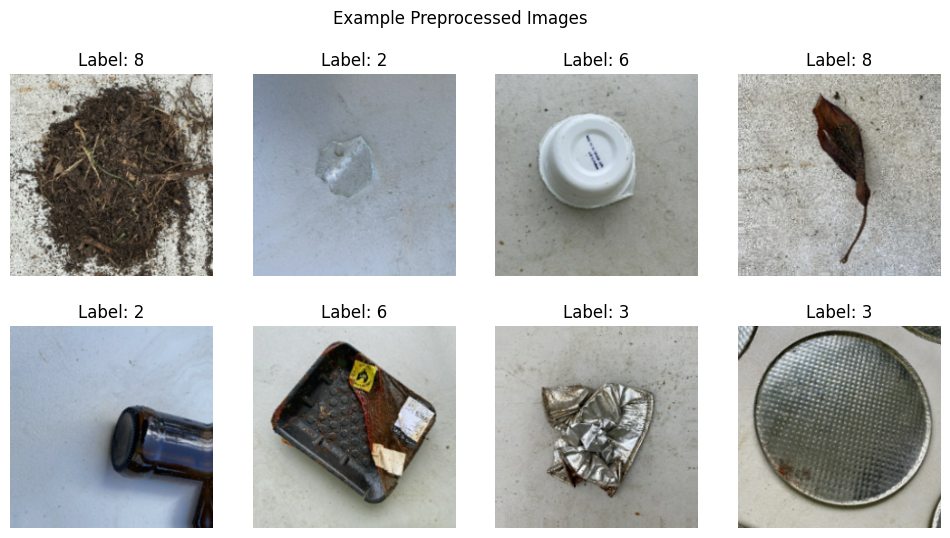

In [49]:
# TODO: Implement image preprocessing

# Set image parameters (based on model requirements or dataset)
IMG_SIZE = (224, 224)   # Change if your model expects something different
BATCH_SIZE = 32

# Directory where your images are stored in subfolders by class
data_dir = './realwaste-main/RealWaste'  

# Split train/val/test using image_dataset_from_directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Normalize pixel values (0-1) as a preprocessing step for CNN
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Optionally add augmentation (recommended for training!)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Apply to dataset (map applies the transformation batch-wise)
train_ds = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x)), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Peek at a batch (sanity check)
import matplotlib.pyplot as plt

images, labels = next(iter(train_ds))
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(f"Label: {labels[i].numpy()}")
    plt.axis('off')
plt.suptitle("Example Preprocessed Images")
plt.show()


### 2.2 Implement CNN Model with Transfer Learning

In [212]:
# TODO: Select an appropriate base model and implement transfer learning
# - Choose from MobileNet, EfficientNet, etc.
# - Add custom classification layers for the 9 waste categories
# - Configure loss function and metrics
from tensorflow import keras
from tensorflow.keras import layers, regularizers

def create_transfer_model(
    img_size=(224, 224),
    num_classes=9,
    base_model_name='EfficientNetB0', 
    dropout_rate=0.3,
    learning_rate=1e-4,
    l2_strength=0.01,
    train_base=False
):
    # Load base model
    base_model_class = getattr(keras.applications, base_model_name)
    base_model = base_model_class(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = train_base  # Freeze during initial training

    # Build classification head
    inputs = keras.Input(shape=img_size + (3,))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_strength)
    )(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',  # assuming integer labels
        metrics=['accuracy', keras.metrics.Precision()]
    )
    
    return model

# Create the model
cnn_model = create_transfer_model()
cnn_model.summary()


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 tf.cast_96 (TFOpLambda)     (None, 7, 7, 1280)        0         
                                                                 
 tf.math.reduce_mean_16 (TF  (None, 1280)              0         
 OpLambda)                                                       
                                                                 
 tf.cast_97 (TFOpLambda)     (None, 1280)              0         
                                                                 
 tf.cast_98 (TFOpLambda)     (None, 1280)              0  

### 2.3 Train and Evaluate the Model

In [213]:
# TODO: Train the CNN model
# - Use appropriate batch size and epochs
# - Implement regularization to prevent overfitting
# - Monitor training and validation metrics
from tensorflow import keras
from tensorflow.keras import layers, regularizers

def create_transfer_model(
    img_size=(224, 224),
    num_classes=9,
    base_model_name='EfficientNetB0',
    dropout_rate=0.3,
    learning_rate=1e-4,
    train_base=False,
    l2_strength=0.01
):
    # Load pre-trained base model without top
    base_model_class = getattr(keras.applications, base_model_name)
    base_model = base_model_class(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = train_base  # Freeze base initially

    # Build the model
    inputs = keras.Input(shape=img_size + (3,))
    x = base_model(inputs, training=False)  # Important: training=False to avoid batchnorm update if frozen
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_strength)
    )(x)
    outputs = layers.Dense(
        num_classes,
        activation='softmax',
        kernel_regularizer=regularizers.l2(l2_strength)
    )(x)

    model = keras.Model(inputs, outputs)

    # Compile for one-hot encoded labels
    model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision()]
)


    return model

# Instantiate the model
model = create_transfer_model()

for image_batch, label_batch in train_ds.take(1):
    print("Image batch shape:", image_batch.shape)  # Expect: (batch_size, 224, 224, 3)
    print("Label batch shape:", label_batch.shape)  # Expect: (batch_size,)
    print("Label example:", label_batch[:5].numpy())  # Should be integers


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 9)
Label example: [[0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Found 4752 files belonging to 9 classes.
1/1 [==============================] - 0s 492ms/step


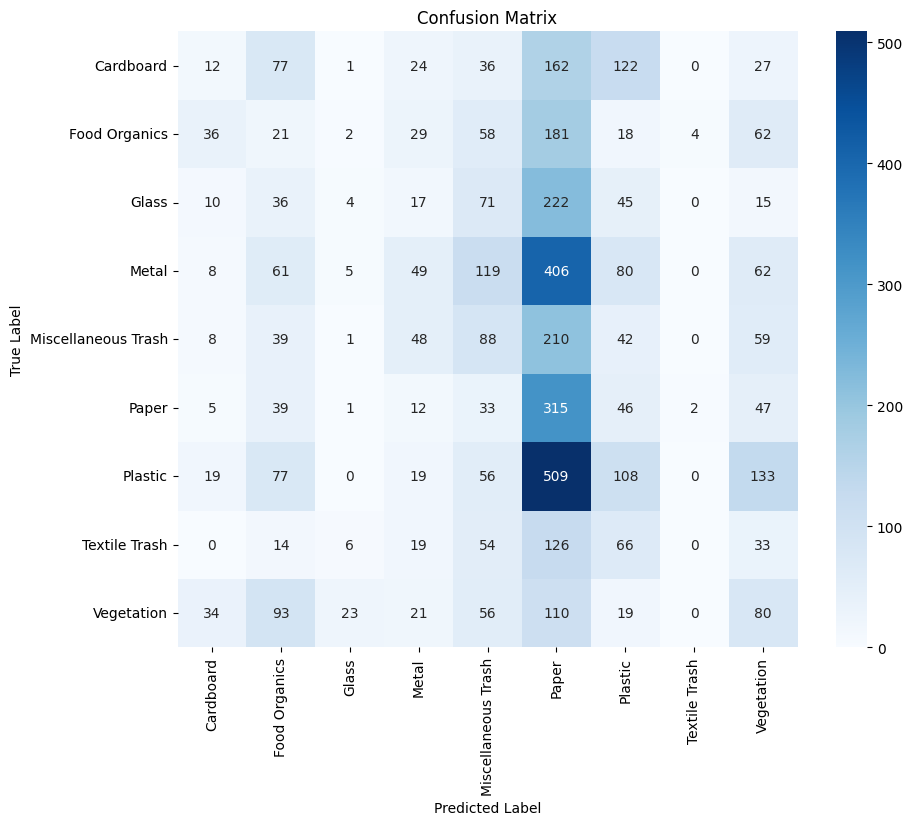


Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.09      0.03      0.04       461
      Food Organics       0.05      0.05      0.05       411
              Glass       0.09      0.01      0.02       420
              Metal       0.21      0.06      0.10       790
Miscellaneous Trash       0.15      0.18      0.17       495
              Paper       0.14      0.63      0.23       500
            Plastic       0.20      0.12      0.15       921
      Textile Trash       0.00      0.00      0.00       318
         Vegetation       0.15      0.18      0.17       436

           accuracy                           0.14      4752
          macro avg       0.12      0.14      0.10      4752
       weighted avg       0.14      0.14      0.11      4752



In [214]:
# TODO: Evaluate model performance
# - Calculate accuracy on test set
# - Generate confusion matrix
# - Analyze error patterns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Constants
NUM_CLASSES = 9
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
TEST_DIR = "./realwaste-main/realwaste" 

# Load test dataset from directory
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False  # So order of predictions matches labels
)

# Store class names for later
class_names = test_ds.class_names

# Prefetch for performance
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)


# Generate predictions and collect true labels
y_true, y_pred = [], []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


### 2.4 Fine-tune the Model

In [ ]:
# TODO: Tune model parameters to improve performance
# - Adjust learning rate
# - Add regularization, dropout
# - Modify architecture if needed
# Data augmentation pipeline
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential, regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
], name="augmentation")

# Build base model
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze for transfer learning phase

inputs = layers.Input(shape=(224, 224, 3), name='input_image')
x = layers.Rescaling(1./255)(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
outputs = layers.Dense(9, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)
model = Model(inputs, outputs, name="EffNet_transfer")

# Initial compile (transfer learning phase)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Train (transfer learning)
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]
)

# Fine-tuning: unfreeze the *last 50 layers* of the base model for further training
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Re-compile with a *lower* learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training (fine-tuning)
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/10
  4/119 ━━━━━━━━━━━━━━━━━━━━ 42s 372ms/step - accuracy: 0.0924 - loss: 4.7093

In [ ]:
# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
if 'accuracy' in history_finetune.history:
    plt.plot(history_finetune.history['accuracy'], label='Fine-tune Train Acc')
    plt.plot(history_finetune.history['val_accuracy'], label='Fine-tune Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
if 'loss' in history_finetune.history:
    plt.plot(history_finetune.history['loss'], label='Fine-tune Train Loss')
    plt.plot(history_finetune.history['val_loss'], label='Fine-tune Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion matrix and classification report
y_true = []
y_pred = []
for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

class_names = ["Cardboard", "Glass", "Metal", "Paper", "Miscellaneous Trash", "Plastic", "Textile Trash", "Vegetation", "Other"]
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

## Part 3: Waste Description Classification

In this section, you will build a text classification model to categorize waste based on descriptions.

### 3.1 Preprocess Text Data

In [ ]:
# TODO: Implement text preprocessing
# - Apply the text preprocessing pipeline created earlier

# Load your waste descriptions CSV
waste_df = pd.read_csv("./Waste Descriptions.csv")

# Quick look
print(waste_df.head())

# Define a simple text cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove punctuation and special chars
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply cleaning
waste_df['description_clean'] = waste_df['description'].apply(clean_text)

# Print a sample
print(waste_df[['description', 'description_clean']].sample(3))

# Split into train/val/test (stratified)
train_df, temp_df = train_test_split(
    waste_df, test_size=0.2, stratify=waste_df['category'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['category'], random_state=42
)

print("Train:", train_df.shape)
print("Val:  ", val_df.shape)
print("Test: ", test_df.shape)


### 3.2 Implement Text Classification Model

In [ ]:
# TODO: Choose and implement a text classification model
# Option A: Traditional ML model (Naive Bayes, Random Forest, etc.)
# Option B: Fine-tune a transformer-based model (BERT, DistilBERT, etc.)

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['category'])
val_labels   = label_encoder.transform(val_df['category'])
test_labels  = label_encoder.transform(test_df['category'])

num_classes = len(label_encoder.classes_)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_texts(texts, max_length=64):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )
train_encodings = tokenize_texts(train_df['description_clean'])
val_encodings   = tokenize_texts(val_df['description_clean'])
test_encodings  = tokenize_texts(test_df['description_clean'])

train_dataset = tf.data.Dataset.from_tensor_slices((
    {**train_encodings, 'labels': train_labels}
)).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {**val_encodings, 'labels': val_labels}
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {**test_encodings, 'labels': test_labels}
)).batch(32)


text_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model.compile(optimizer=optimizer)

history = text_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3  
)

In [ ]:
loss = model.evaluate(test_dataset)
print(f"Test loss: {loss:.3f}")


### 3.3 Train and Evaluate the Model

In [ ]:
# TODO: Train the text classification model
# - Use appropriate training parameters
# - Monitor training progress

# Set training parameters
EPOCHS = 3  
BATCH_SIZE = 32

# Early stopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=1,  # Stop if val_loss doesn't improve for 1 epoch
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1
)


In [ ]:
# Plot training progress

import matplotlib.pyplot as plt

# --- Find the actual accuracy metric key ---
history_keys = list(history.history.keys())
acc_key = None
val_acc_key = None

# Common accuracy keys (in order of preference)
acc_keys = ['accuracy', 'categorical_accuracy', 'acc']
for k in acc_keys:
    if k in history_keys:
        acc_key = k
        break
for k in ['val_' + a for a in acc_keys]:
    if k in history_keys:
        val_acc_key = k
        break

# --- Plot ---
plt.figure(figsize=(12, 5))


# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# TODO: Evaluate model performance
# - Calculate accuracy on test set
# - Generate confusion matrix
# - Analyze error patterns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions for the test set
y_true = []
y_pred = []

for batch in test_dataset:
    labels = batch['labels']
    inputs = {k: v for k, v in batch.items() if k != 'labels'}
    logits = model(inputs, training=False).logits
    batch_pred = np.argmax(logits.numpy(), axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(batch_pred)


# Calculate test accuracy
test_accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"Test Accuracy: {test_accuracy:.3f}")

# Generate classification report
target_names = list(label_encoder.classes_)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Generate and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()



### 3.4 Create Classification Function

In [ ]:
# TODO: Create a function that takes a text description and returns the predicted waste category
def classify_waste_description(description):
    """
    Classifies a waste description into an appropriate category.

    Args:
        description (str): Text description of waste item

    Returns:
        str: Predicted waste category
    """
    # Clean the description (should match your training preprocessing)
    def clean_text(text):
        import re
        text = str(text).lower()
        text = re.sub(r'[^a-z0-9\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    cleaned = clean_text(description)
    # Tokenize using the same tokenizer as training
    enc = tokenizer(
        [cleaned],  # batch of size 1
        padding='max_length',
        truncation=True,
        max_length=64,
        return_tensors='tf'
    )
    # Get model prediction (no training, just inference)
    outputs = model(enc, training=False)
    pred_class = outputs.logits.numpy().argmax(axis=1)[0]
    # Map label index to category name
    category = label_encoder.inverse_transform([pred_class])[0]
    return category

# Example usage:
desc = "empty glass bottle with broken top"
print("Predicted category:", classify_waste_description(desc))


## Part 4: Recycling Instruction Generation with RAG

In this section, you will implement a Retrieval-Augmented Generation (RAG) system to generate recycling instructions.

### 4.1 Preprocess Documents for Retrieval

In [ ]:
# TODO: Prepare documents for retrieval
# - Process policy documents and disposal instructions
# - Create embeddings for efficient retrieval
import pandas as pd
from sentence_transformers import SentenceTransformer

# Load JSON and CSV properly
policy_docs = pd.read_json("waste policy documents.json")    # Use read_json for JSON!
desc_docs   = pd.read_csv("Waste Descriptions.csv")          # CSV as normal

# Select text and metadata columns (update column names as needed)
policy_texts = policy_docs['document_text'].fillna("").tolist()
policy_meta  = policy_docs.to_dict('records')

desc_texts = desc_docs['disposal_instruction'].fillna("").tolist()
desc_meta  = desc_docs.to_dict('records')

# Combine into a single corpus (for a unified search experience)
all_texts = policy_texts + desc_texts
all_meta  = policy_meta + desc_meta

# Load sentence transformer model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

print("Generating embeddings...")
doc_embeddings = embedding_model.encode(all_texts, show_progress_bar=True)
print("Embeddings shape:", doc_embeddings.shape)

# Check a sample embedding & associated metadata
print("\nSample doc:", all_texts[0][:100], "...")
print("Sample embedding:", doc_embeddings[0][:5])
print("Sample metadata:", all_meta[0])


### 4.2 Implement RAG-based System

In [ ]:
# TODO: Select a pre-trained language model and implement RAG
# - Choose an appropriate language model
# - Create a retrieval mechanism
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
from sklearn.metrics.pairwise import cosine_similarity


retrieval_model = SentenceTransformer('all-MiniLM-L6-v2')
gen_model_name  = "gpt2"  # Or try 'distilgpt2', 'gpt2-medium', etc.
tokenizer = AutoTokenizer.from_pretrained(gen_model_name)
generator = AutoModelForCausalLM.from_pretrained(gen_model_name)

# Create a retrieval function
def retrieve_relevant_docs(query, doc_embeddings, documents, metadata, top_k=3):
    # Embed query
    query_emb = retrieval_model.encode([query])
    # Compute similarities
    similarities = cosine_similarity(query_emb, doc_embeddings)[0]
    # Rank and select top_k
    top_idx = similarities.argsort()[-top_k:][::-1]
    results = [(documents[i], metadata[i], similarities[i]) for i in top_idx]
    return results

query = "What do I do with soiled pizza boxes?"
top_docs = retrieve_relevant_docs(query, doc_embeddings, all_texts, all_meta, top_k=3)

print("Top retrieved docs:")
for content, meta, score in top_docs:
    print(f"Score: {score:.3f}\nText: {content[:100]}...\nMeta: {meta}\n")


### 4.3 Adjust and Evaluate the System

In [ ]:
# TODO: Train the RAG-based system
# - Adjust sampling methods/parameters
import numpy as np
from types import SimpleNamespace as Namespace
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd

policy_texts = policy_docs['document_text'].fillna("").tolist()
desc_texts   = desc_docs['disposal_instruction'].fillna("").tolist()
all_texts    = policy_texts + desc_texts

# Build Retriever 
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
print("Encoding documents...")
document_embeddings = embedding_model.encode(all_texts, show_progress_bar=True)

# Build Generator 
tokenizer = AutoTokenizer.from_pretrained('gpt2')  
model = AutoModelForCausalLM.from_pretrained('gpt2')
generator = Namespace(tokenizer=tokenizer, model=model)

# RAG function
def generate_rag_instruction(
    query, policy_embeddings, policy_texts, retriever, generator,
    top_k=2, temperature=1.0, max_new_tokens=64
):
    # Retrieve relevant snippets
    query_emb = retriever.encode([query])
    similarities = np.inner(query_emb, policy_embeddings)[0]
    top_indices = similarities.argsort()[::-1][:top_k]
    retrieved_snippets = [policy_texts[i] for i in top_indices]
    context = "\n".join(retrieved_snippets)
    prompt = f"Instruction context:\n{context}\n\nQuestion: {query}\nInstruction:"
    
    # Tokenize prompt with truncation (to model max length)
    inputs = generator.tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=generator.tokenizer.model_max_length  # use model's max input length
    )
    
    # Generate response, set how much to generate
    outputs = generator.model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        do_sample=True,
        temperature=temperature,
        max_new_tokens=max_new_tokens,  # controls output length
        top_p=0.95,
        top_k=50,
        num_return_sequences=1
    )
    response = generator.tokenizer.decode(outputs[0], skip_special_tokens=True)
    instruction = response.split("Instruction:")[-1].strip()
    return instruction


# Example usage
sample_questions = [
    "How should I dispose of a broken glass bottle?",
    "What is the correct bin for oily pizza boxes?",
    "Can textiles go into regular recycling?",
]

for question in sample_questions:
    instruction = generate_rag_instruction(
        query=question,
        policy_embeddings=document_embeddings,
        policy_texts=all_texts,
        retriever=embedding_model,
        generator=generator,
        top_k=2,
        temperature=0.8,
        max_new_tokens=64   
    )
    print(f"Q: {question}")
    print(f"Generated Instruction: {instruction}")
    print("-" * 50)


In [ ]:
# TODO: Evaluate the quality of generated instructions
# - Test with various waste categories
# - Assess relevance and accuracy

def evaluate_rag_system(test_queries, policy_embeddings, policy_texts, retriever, generator, print_output=True):
    results = []
    for query in test_queries:
        instruction = generate_rag_instruction(
            query,
            policy_embeddings=policy_embeddings,
            policy_texts=policy_texts,
            retriever=retriever,
            generator=generator,
            top_k=2,
            temperature=0.8        )
        if print_output:
            print(f"Query: {query}")
            print(f"Generated Instruction: {instruction}")
            print("-" * 50)
        results.append({'query': query, 'generated_instruction': instruction})
    return results

# Example queries to test a range of waste categories
test_queries = [
    "Where do I throw away plastic bags?",
    "How should I dispose of old clothes?",
    "Can glass jars go in the recycling bin?",
    "What to do with leftover food waste?",
    "How do I get rid of broken electronics?",
    "Can greasy pizza boxes be recycled?",
]

# Run the evaluation (replace variables with your objects)
eval_results = evaluate_rag_system(
    test_queries=test_queries,
    policy_embeddings=document_embeddings,
    policy_texts=all_texts,
    retriever=embedding_model,
    generator=Namespace(tokenizer=tokenizer, model=model),  # or your own wrapper class
    print_output=True
)


### 4.4 Create Instruction Generation Function

In [ ]:
# TODO: Create a function that takes a waste category and generates recycling instructions
def generate_recycling_instructions(waste_category):
    """
    Generates detailed recycling instructions for a given waste category.

    Args:
        waste_category (str): Waste category

    Returns:
        str: Detailed recycling instructions
        list: Relevant policy document texts
    """
    # Find recycling instructions from the descriptions dataset
    instructions = desc_docs[desc_docs['category'].str.lower() == waste_category.lower()]['disposal_instruction'].dropna().tolist()
    if not instructions:
        instructions = ["No specific instructions found for this category. Please consult your local recycling guidelines."]
    
    # Find relevant policy docs (if there's a category field; else return all docs)
    if 'category' in policy_docs.columns:
        relevant_policies = policy_docs[policy_docs['category'].str.lower() == waste_category.lower()]['document_text'].dropna().tolist()
    else:
        relevant_policies = policy_docs['document_text'].dropna().tolist()
    
    # Compose a friendly, detailed output
    detailed_instructions = f"**Recycling instructions for '{waste_category}':**\n"
    for i, instr in enumerate(instructions, 1):
        detailed_instructions += f"{i}. {instr}\n"
    
    if relevant_policies:
        detailed_instructions += "\nRelevant policy documents:\n"
        for i, doc in enumerate(relevant_policies[:3], 1):  # show up to 3
            detailed_instructions += f"- {doc[:120]}{'...' if len(doc) > 120 else ''}\n"  # Truncate for readability
    else:
        detailed_instructions += "\nNo specific policy documents found."
    
    return detailed_instructions, relevant_policies

# Example usage:
category = "Plastic"
instructions, policy_docs = generate_recycling_instructions(category)
print(instructions)


## Part 5: Integrated Waste Management Assistant

In this section, you will integrate all three models into a unified waste management assistant.

### 5.1 Design Integration Architecture

In [ ]:
# TODO: Design an architecture that integrates all three models
# - Create interfaces between components
# - Handle input/output flow
class EcoSortAssistant:
    def __init__(self, image_model, text_model, label_encoder, rag_generator, tokenizer):
        self.image_model = model          # Trained Keras CNN model
        self.text_model = text_model            # Trained HuggingFace BERT model (TF version)
        self.label_encoder = label_encoder      # Fitted LabelEncoder
        self.rag_generator = rag_generator      # RAG generator function
        self.tokenizer = tokenizer              # HuggingFace tokenizer

    def classify_image(self, image):
        img_input = self.preprocess_image(image)
        preds = self.image_model.predict(img_input)
        class_idx = np.argmax(preds, axis=1)[0]
        category = self.label_encoder.inverse_transform([class_idx])[0]
        return category

    def preprocess_image(self, image):   # <--- ADD self HERE
        import tensorflow as tf
        IMG_SIZE = (224, 224)
        if isinstance(image, str):
            image = tf.io.read_file(image)
            image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, IMG_SIZE)
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.expand_dims(image, axis=0)
        return image

    def preprocess_and_tokenize(self, text):
        return self.tokenizer([text], truncation=True, padding='max_length', max_length=64, return_tensors="tf")
    
    def classify_text(self, description):
        inputs = self.preprocess_and_tokenize(description)
        preds = self.text_model(**inputs)
        class_idx = np.argmax(preds.logits.numpy(), axis=1)[0]
        category = self.label_encoder.inverse_transform([class_idx])[0]
        return category
    
    def generate_instructions(self, waste_category):
        instructions, docs = self.rag_generator(waste_category)
        return instructions, docs

    def handle_input(self, image=None, description=None):
        if image is not None:
            category = self.classify_image(image)
        elif description is not None:
            category = self.classify_text(description)
        else:
            raise ValueError("Must provide an image or a description.")
        instructions, relevant_docs = self.generate_instructions(category)
        return {
            "predicted_category": category,
            "instructions": instructions,
            "relevant_docs": relevant_docs
        }


### 5.2 Implement Integrated Assistant

In [ ]:
# TODO: Implement the integrated waste management assistant

def waste_management_assistant(input_data, input_type="image"):
    """
    Integrated waste management assistant that processes either images or text descriptions
    and returns waste classification and recycling instructions.

    Args:
        input_data: Either an image file path/array or a text description
        input_type (str): Type of input - "image" or "text"

    Returns:
        dict: Dictionary containing waste category, confidence, and recycling instructions
    """

    # Predict category from image
    if input_type == "image":
        # Assume preprocess_image returns model-ready array of shape (1, 224, 224, 3)
        img = preprocess_image(input_data)
        preds = model.predict(img)
        category_idx = np.argmax(preds)
        confidence = float(np.max(preds))
        category = label_encoder.inverse_transform([category_idx])[0]

    # Predict category from text
    elif input_type == "text":
        # Assume tokens is a dict from tokenizer (with keys like 'input_ids', 'attention_mask')
        outputs = text_model(**tokens)
        logits = outputs.logits
        preds = np.argmax(logits.numpy(), axis=1)

        if hasattr(preds, "logits"):  # Hugging Face style
            probs = tf.nn.softmax(preds.logits, axis=1).numpy()
        else:  # Keras style
            probs = preds if hasattr(preds, "numpy") else np.array(preds)
        category_idx = np.argmax(probs)
        confidence = float(np.max(probs))
        category = label_encoder.inverse_transform([category_idx])[0]

    else:
        raise ValueError("input_type must be 'image' or 'text'.")

    # Generate recycling instructions using RAG
    instructions, relevant_docs = generate_recycling_instructions(category)

    return {
        "waste_category": category,
        "confidence": confidence,
        "instructions": instructions,
        "relevant_docs": relevant_docs
    }


### 5.3 Evaluate the Integrated System

In [ ]:
# TODO: Evaluate the integrated system on test cases
# - Test with images from test dataset
# - Test with text descriptions from test dataset
# - Assess overall performance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
text_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

ecosort_assistant = EcoSortAssistant(
    image_model=model,           # Your CNN Keras model!
    text_model=text_model,       # Your BERT, TFBertForSequenceClassification, or other text model
    label_encoder=label_encoder,
    rag_generator=rag_generator,
    tokenizer=tokenizer 
)
# Load test image dataframe (update data_dir to your image folder)
import os
data_dir = "realwaste-main/RealWaste"
image_data = []
for category in sorted(os.listdir(data_dir)):
    cat_path = os.path.join(data_dir, category)
    if not os.path.isdir(cat_path):
        continue
    for fname in os.listdir(cat_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image_data.append({"filepath": os.path.join(cat_path, fname), "category": category})
test_image_df = pd.DataFrame(image_data)

# Test image classification
image_true, image_pred = [], []
for idx, row in test_image_df.iterrows():
    img_path = row['filepath']
    true_category = row['category']
    pred_category = ecosort_assistant.classify_image(img_path)
    image_true.append(true_category)
    image_pred.append(pred_category)

print("\nImage Classification Report:")
print(classification_report(image_true, image_pred))
cm_img = confusion_matrix(image_true, image_pred, labels=ecosort_assistant.label_encoder.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm_img, annot=True, fmt='d', cmap='Blues',
            xticklabels=ecosort_assistant.label_encoder.classes_,
            yticklabels=ecosort_assistant.label_encoder.classes_)
plt.title("Confusion Matrix (Image Classification)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Test text classification (assuming you have test_text_df with 'description' and 'category' columns)
text_true, text_pred = [], []
for idx, row in test_text_df.iterrows():
    description = row['description']
    true_category = row['category']
    pred_category = ecosort_assistant.classify_text(description)
    text_true.append(true_category)
    text_pred.append(pred_category)

print("\nText Classification Report:")
print(classification_report(text_true, text_pred))
cm_txt = confusion_matrix(text_true, text_pred, labels=ecosort_assistant.label_encoder.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm_txt, annot=True, fmt='d', cmap='Blues',
            xticklabels=ecosort_assistant.label_encoder.classes_,
            yticklabels=ecosort_assistant.label_encoder.classes_)
plt.title("Confusion Matrix (Text Classification)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Example: Print some predictions + instructions
for i in range(5):
    img_path = test_image_df.iloc[i]['filepath']
    desc = test_text_df.iloc[i]['description']
    cat_img = ecosort_assistant.classify_image(img_path)
    cat_txt = ecosort_assistant.classify_text(desc)
    instr_img, docs_img = ecosort_assistant.generate_instructions(cat_img)
    instr_txt, docs_txt = ecosort_assistant.generate_instructions(cat_txt)
    print(f"\nImage: {img_path}\nPredicted: {cat_img}\nInstructions: {instr_img[:100]}...")
    print(f"Text: {desc}\nPredicted: {cat_txt}\nInstructions: {instr_txt[:100]}...")


## Submission Guidelines

1. Make sure all code cells are properly commented and annotated
2. Ensure that all functions are implemented and working correctly
3. Verify that all evaluation metrics are calculated and analyzed
4. Double-check that the integrated system works as expected
5. Submit your completed and annotated Jupyter notebook file

Remember to demonstrate your understanding of the underlying concepts and provide justification for your design decisions throughout the notebook.